In [1]:
from train_pipeline import train, _train_seed

import os
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf


def load_cfg(overrides=()):
    # with initialize_config_dir(config_dir="/app/notebooks/draft_02/conf"):
    with initialize(version_base=None, config_path="./conf"):
        cfg = compose(config_name='config', overrides=list(overrides))
        return cfg

from IPython.display import clear_output

cfg = load_cfg(overrides=[
    "+device=cuda:0",
    "total_steps=1000",
])

In [2]:
from train_pipeline import *

In [3]:
random_seed = 0

In [12]:
# model_input = model_input[:, :1000]

In [13]:
from tqdm.auto import tqdm

In [14]:
def extract_grad(model):
    grads = {}

    for i, layer in enumerate(model.net):
        if hasattr(layer, 'linear'):
            W = layer.linear.weight
        else:
            W = layer.weight

        G = W.grad.detach().cpu()

        grads[f'w_{i}_std'] = G.std()

    return grads

In [15]:
def plot_grads(model):
    plt.figure(figsize=(20, 4)) # width and height of the plot
    legends = []

    for i, (layer) in enumerate(model.net):
        if hasattr(layer, 'linear'):
            W = layer.linear.weight
        else:
            W = layer.weight

        G = W.grad.detach().cpu()
        print('grad %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(G.shape), G.mean(), G.std(), G.std() / W.std()))
        hy, hx = torch.histogram(G, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer {i} {tuple(G.shape)}')

    plt.legend(legends)
    plt.title('weights gradient distribution');
    plt.show()

In [16]:
seed_all(random_seed)
print("Setting seed to", random_seed)

print("*" * 80)
print("\n")
print(OmegaConf.to_yaml(cfg))
print()
print("*" * 80)

device = cfg["device"]

model_input, ground_truth, H, W = load_data(cfg)
model_input, ground_truth = model_input.to(device), ground_truth.to(device)

out_features = ground_truth.shape[-1]
model = instantiate(cfg["model"], out_features=out_features)
model.to(device)

total_steps = cfg["total_steps"]
steps_til_summary = cfg.logging["steps_till_summary"]

total_params = count_parameters(model)

optimizer = instantiate(cfg.optimizer, params=model.parameters())

Setting seed to 0
********************************************************************************


image: sasha.jpg
image_dir: ../../data
image_W: 512
use_wandb: true
is_debug: false
total_steps: 1000
random_seed:
- 0
- 1
- 2
- 3
- 4
model:
  _target_: spellbook.siren.model.Siren
  in_features: 2
  out_features: none
  hidden_features: 256
  hidden_layers: 3
  init_c: 6
  first_layer_init_c: 1
  outermost_linear: true
logging:
  logger:
    _target_: spellbook.logging.wandb.WandbLogger
    project: 01_splitnet__${image}
  steps_till_summary: 500
optimizer:
  _target_: torch.optim.AdamW
  weight_decay: 0.0
  lr: 0.0001
device: cuda:0


********************************************************************************
+---------------------+------------+
|       Modules       | Parameters |
+---------------------+------------+
| net.0.linear.weight |    512     |
|  net.0.linear.bias  |    256     |
| net.1.linear.weight |   65536    |
|  net.1.linear.bias  |    256     |
| net.2.linear.

  0%|          | 0/1001 [00:00<?, ?it/s]

grad   (256, 2) | mean +0.000038 | std 8.491684e-04 | grad:data ratio 2.862873e-03
grad (256, 256) | mean -0.000005 | std 1.147006e-03 | grad:data ratio 3.896695e-01
grad (256, 256) | mean -0.000001 | std 4.101878e-03 | grad:data ratio 1.390517e+00
grad (256, 256) | mean -0.000053 | std 7.245726e-03 | grad:data ratio 2.458689e+00
grad   (3, 256) | mean -0.005757 | std 1.137541e-01 | grad:data ratio 3.844111e+01


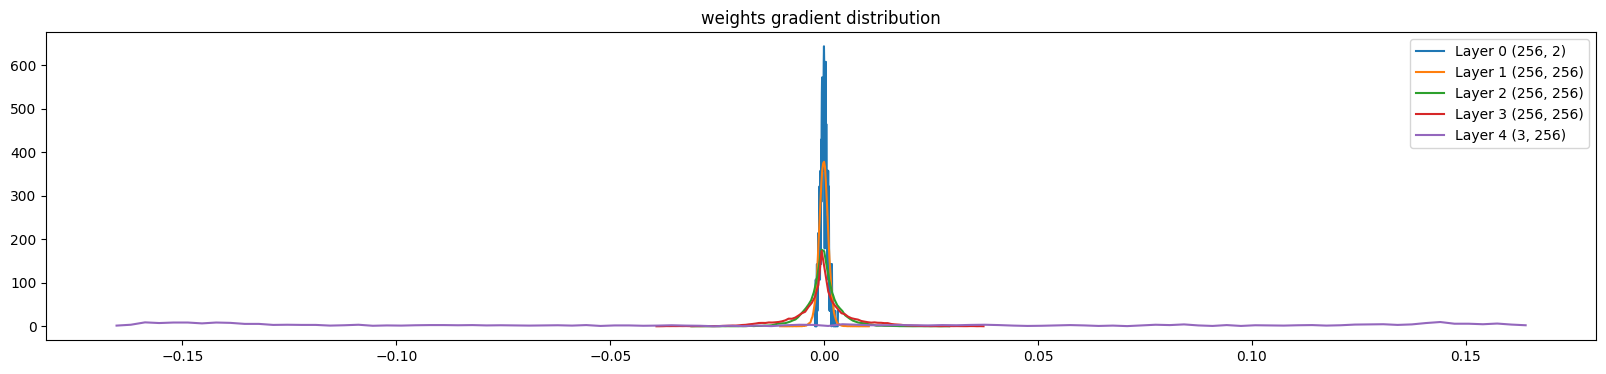

Step 0, Total loss 0.141381 psnr=8.496


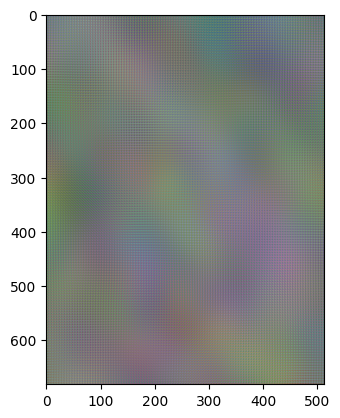

grad   (256, 2) | mean +0.000000 | std 2.783956e-05 | grad:data ratio 9.376490e-05
grad (256, 256) | mean -0.000000 | std 2.605878e-05 | grad:data ratio 7.912293e-03
grad (256, 256) | mean -0.000000 | std 2.334470e-05 | grad:data ratio 7.547228e-03
grad (256, 256) | mean -0.000000 | std 1.656455e-05 | grad:data ratio 5.444699e-03
grad   (3, 256) | mean -0.000049 | std 6.195611e-04 | grad:data ratio 1.404123e-01


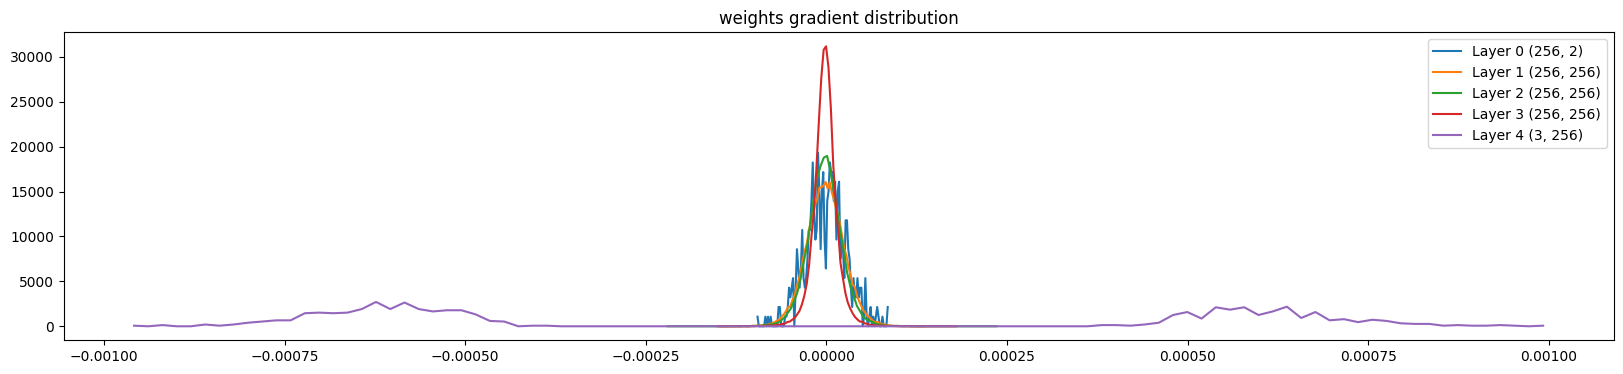

grad   (256, 2) | mean +0.000000 | std 1.385294e-05 | grad:data ratio 4.661338e-05
grad (256, 256) | mean -0.000000 | std 1.228507e-05 | grad:data ratio 3.524401e-03
grad (256, 256) | mean +0.000000 | std 1.387515e-05 | grad:data ratio 4.282082e-03
grad (256, 256) | mean -0.000000 | std 1.121623e-05 | grad:data ratio 3.611710e-03
grad   (3, 256) | mean -0.000026 | std 3.492838e-04 | grad:data ratio 7.598805e-02


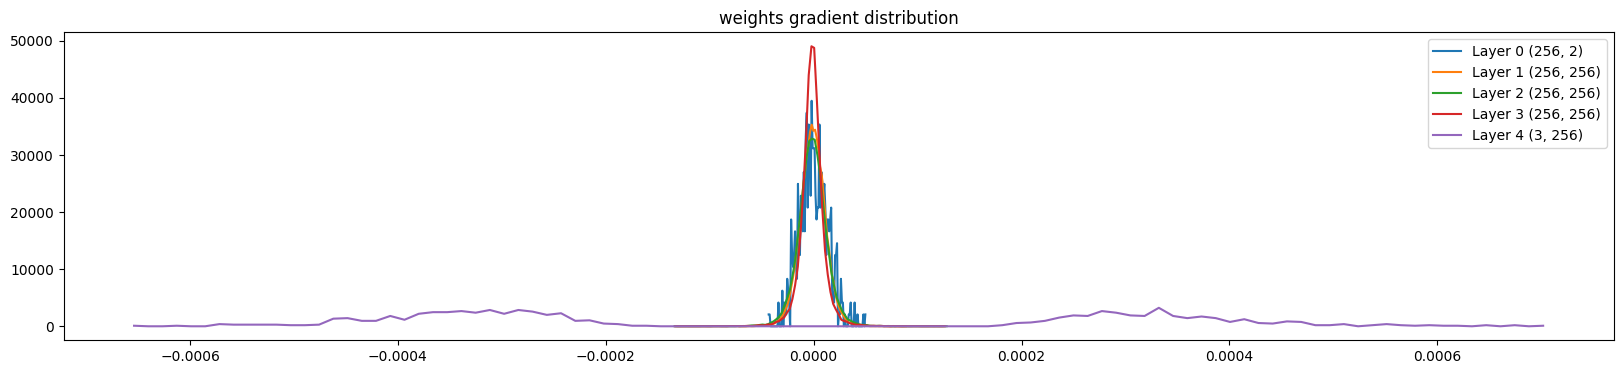

grad   (256, 2) | mean +0.000000 | std 1.121059e-05 | grad:data ratio 3.768373e-05
grad (256, 256) | mean +0.000000 | std 9.039750e-06 | grad:data ratio 2.467284e-03
grad (256, 256) | mean +0.000000 | std 1.118826e-05 | grad:data ratio 3.279226e-03
grad (256, 256) | mean -0.000000 | std 9.197527e-06 | grad:data ratio 2.885061e-03
grad   (3, 256) | mean -0.000019 | std 2.591133e-04 | grad:data ratio 5.449547e-02


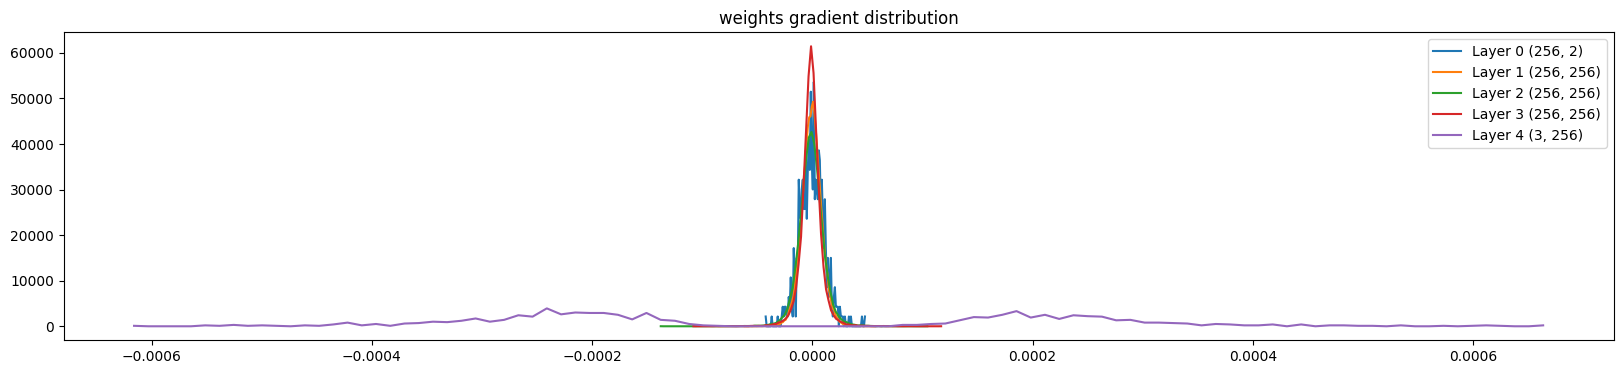

grad   (256, 2) | mean -0.000001 | std 1.149147e-05 | grad:data ratio 3.859917e-05
grad (256, 256) | mean +0.000000 | std 8.216264e-06 | grad:data ratio 2.153798e-03
grad (256, 256) | mean -0.000000 | std 1.172143e-05 | grad:data ratio 3.269443e-03
grad (256, 256) | mean -0.000000 | std 7.551016e-06 | grad:data ratio 2.302604e-03
grad   (3, 256) | mean -0.000012 | std 1.893979e-04 | grad:data ratio 3.869451e-02


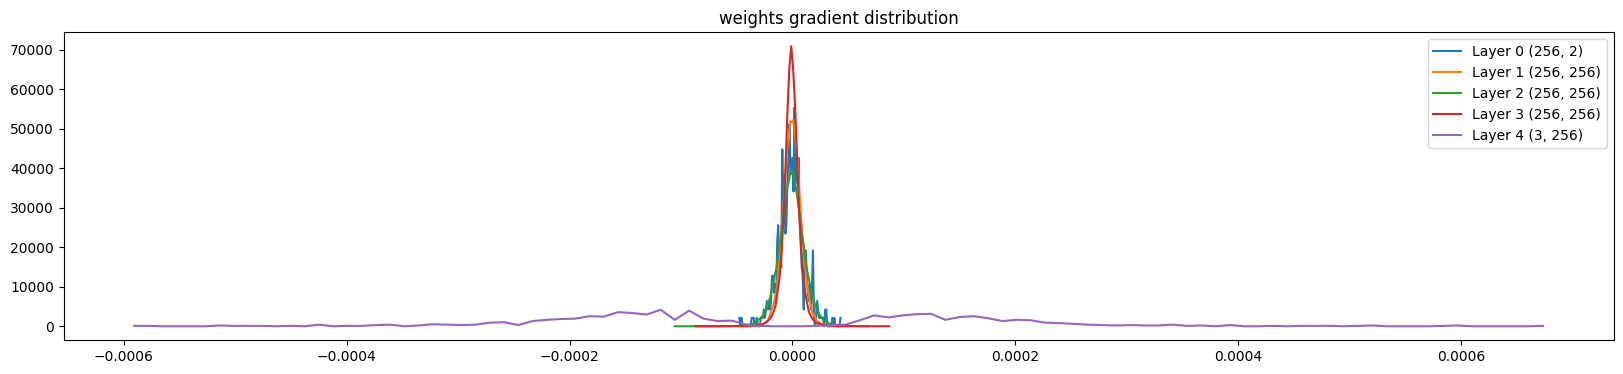

grad   (256, 2) | mean -0.000000 | std 6.074948e-06 | grad:data ratio 2.039298e-05
grad (256, 256) | mean +0.000000 | std 5.218163e-06 | grad:data ratio 1.326954e-03
grad (256, 256) | mean -0.000000 | std 6.721688e-06 | grad:data ratio 1.796129e-03
grad (256, 256) | mean -0.000000 | std 5.776307e-06 | grad:data ratio 1.708979e-03
grad   (3, 256) | mean -0.000012 | std 1.656651e-04 | grad:data ratio 3.297037e-02


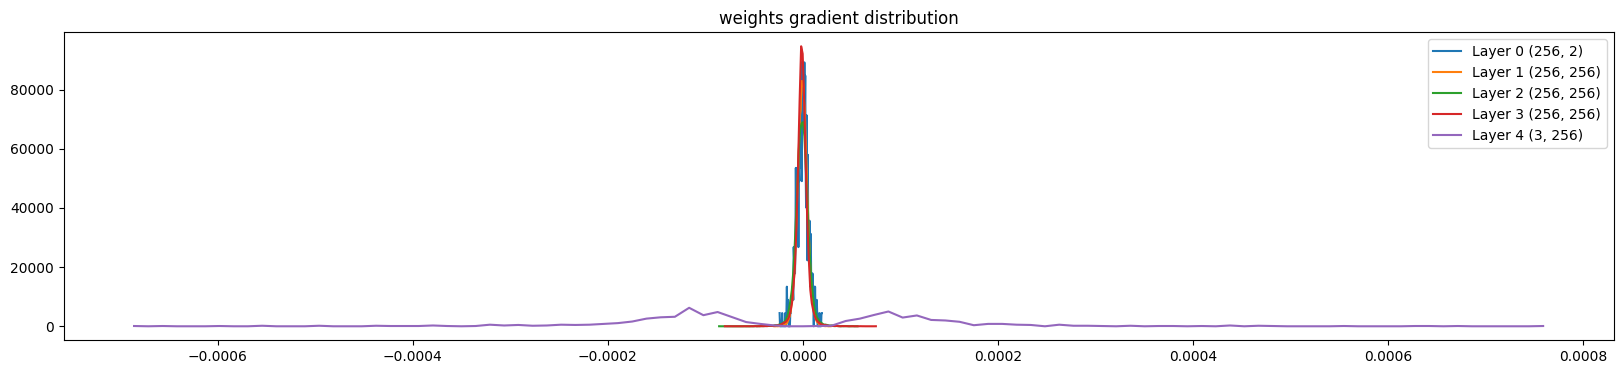

Step 500, Total loss 0.002207 psnr=26.562


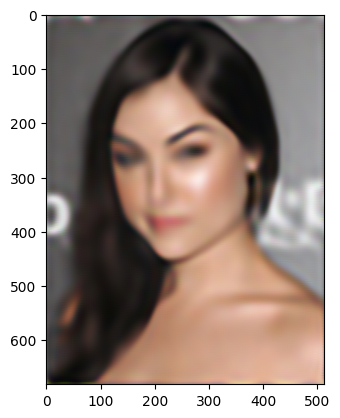

grad   (256, 2) | mean +0.000000 | std 9.894186e-06 | grad:data ratio 3.320180e-05
grad (256, 256) | mean +0.000000 | std 6.479694e-06 | grad:data ratio 1.611268e-03
grad (256, 256) | mean +0.000000 | std 5.752946e-06 | grad:data ratio 1.483537e-03
grad (256, 256) | mean -0.000000 | std 4.764145e-06 | grad:data ratio 1.366294e-03
grad   (3, 256) | mean -0.000010 | std 1.464246e-04 | grad:data ratio 2.847221e-02


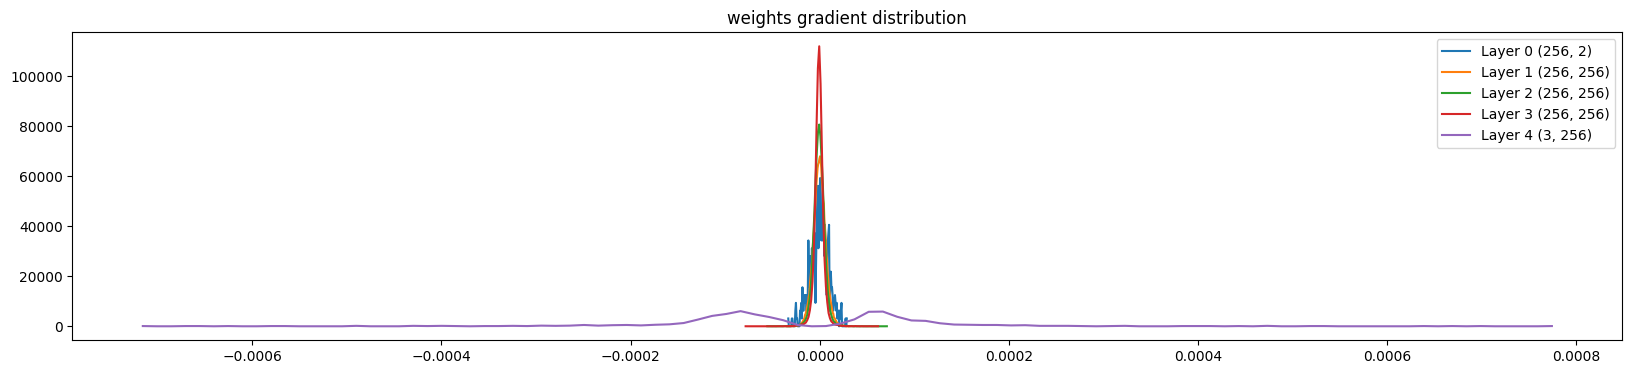

grad   (256, 2) | mean -0.000001 | std 6.708281e-05 | grad:data ratio 2.250543e-04
grad (256, 256) | mean +0.000000 | std 4.672269e-05 | grad:data ratio 1.141831e-02
grad (256, 256) | mean +0.000000 | std 4.129227e-05 | grad:data ratio 1.033277e-02
grad (256, 256) | mean +0.000000 | std 2.089261e-05 | grad:data ratio 5.809123e-03
grad   (3, 256) | mean +0.000006 | std 1.369871e-04 | grad:data ratio 2.602956e-02


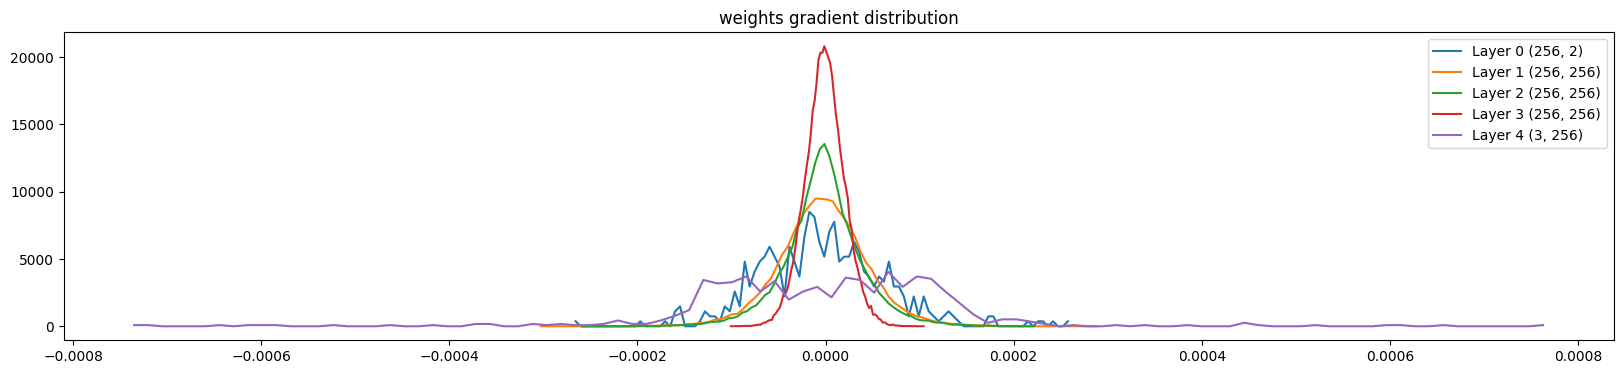

grad   (256, 2) | mean -0.000003 | std 9.353828e-05 | grad:data ratio 3.137463e-04
grad (256, 256) | mean -0.000000 | std 6.490661e-05 | grad:data ratio 1.564836e-02
grad (256, 256) | mean +0.000000 | std 5.607339e-05 | grad:data ratio 1.367074e-02
grad (256, 256) | mean +0.000000 | std 3.035104e-05 | grad:data ratio 8.189624e-03
grad   (3, 256) | mean +0.000001 | std 1.334317e-04 | grad:data ratio 2.476839e-02


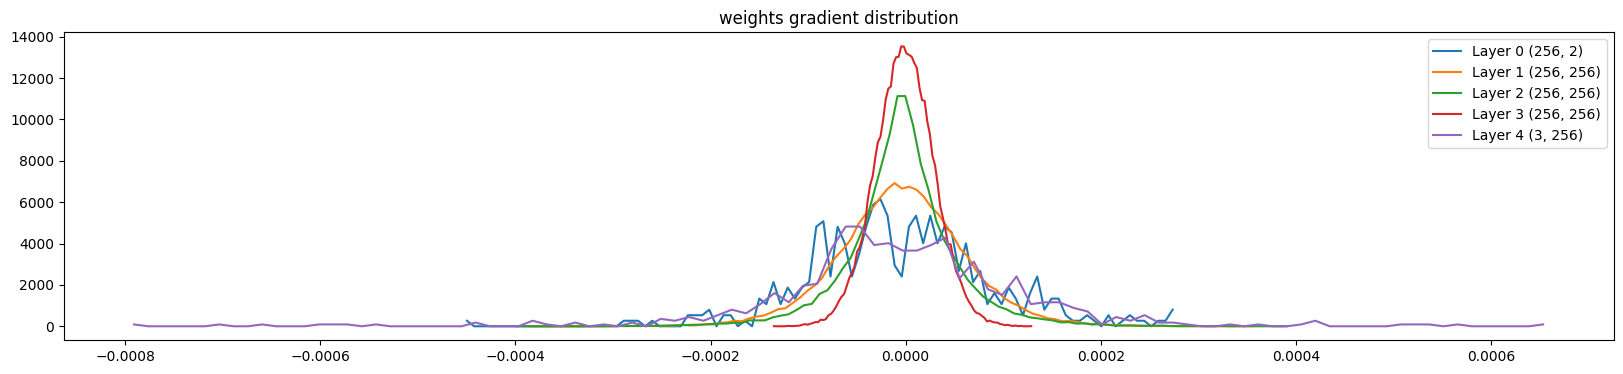

grad   (256, 2) | mean -0.000007 | std 2.386623e-04 | grad:data ratio 8.003853e-04
grad (256, 256) | mean -0.000000 | std 1.693479e-04 | grad:data ratio 4.038900e-02
grad (256, 256) | mean -0.000000 | std 1.457912e-04 | grad:data ratio 3.477037e-02
grad (256, 256) | mean -0.000000 | std 7.478711e-05 | grad:data ratio 1.962288e-02
grad   (3, 256) | mean -0.000078 | std 6.331604e-04 | grad:data ratio 1.147894e-01


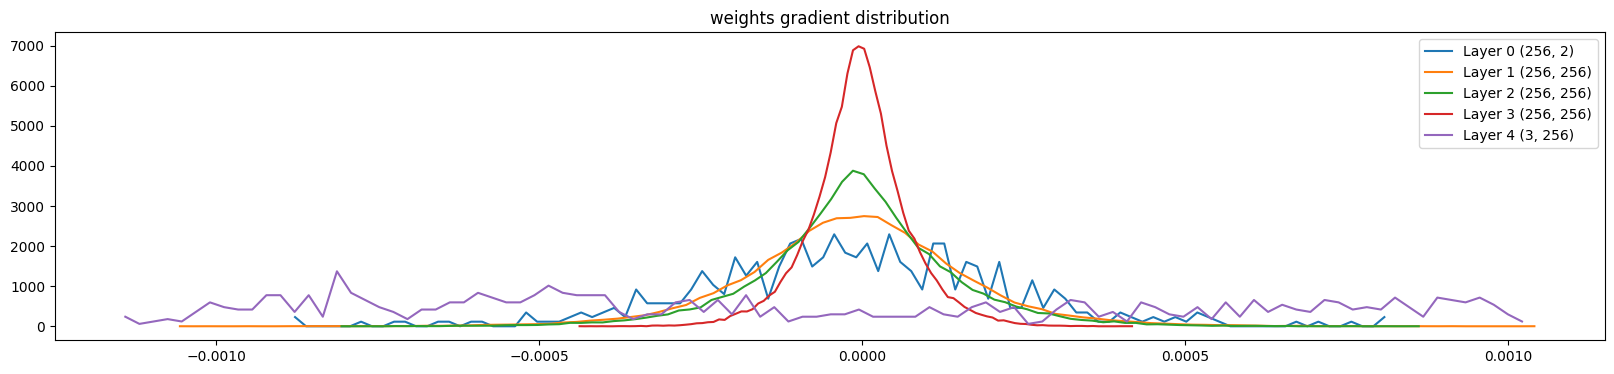

grad   (256, 2) | mean +0.000003 | std 5.499147e-05 | grad:data ratio 1.843984e-04
grad (256, 256) | mean -0.000000 | std 4.143910e-05 | grad:data ratio 9.799418e-03
grad (256, 256) | mean -0.000000 | std 2.630511e-05 | grad:data ratio 6.156052e-03
grad (256, 256) | mean -0.000000 | std 1.346736e-05 | grad:data ratio 3.445663e-03
grad   (3, 256) | mean -0.000012 | std 1.178850e-04 | grad:data ratio 2.089848e-02


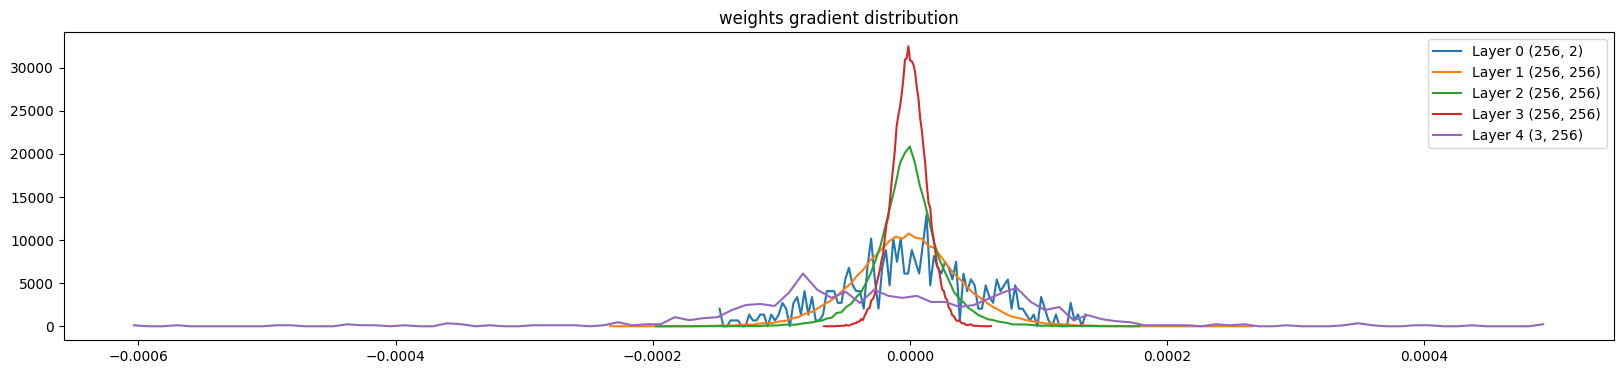

Step 1000, Total loss 0.001239 psnr=29.068


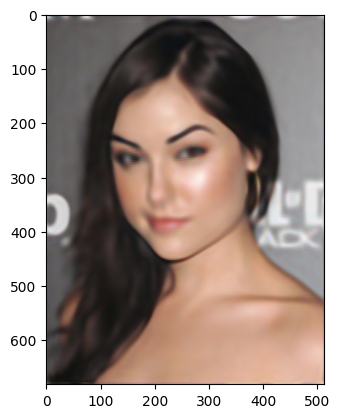

In [18]:
act_means = []
act_stds = []

grads = []

for step in tqdm(range(total_steps+1)):
    activations = model.forward_with_activations(model_input)
    model_output = activations['layer_4_act']
    
    mse, psnr = mse_and_psnr(model_output, ground_truth)
    loss = mse

    log_dic = {"step": 0, "mse": mse.item(), "psnr": psnr.item()}

    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    grads.append(extract_grad(model))

    act_means_it = {k:v.detach().mean().cpu().item() for k,v in activations.items()}
    act_stds_it = {k:v.detach().std().cpu().item() for k,v in activations.items()}

    act_means.append(act_means_it)
    act_stds.append(act_stds_it)
    # G_means_it = {k:v.grad.detach().mean().cpu() for k,v in activations.items()}
    # G_stds_it = {k:v.grad.detach().std().cpu() for k,v in activations.items()}


    if not step % 100:
        plot_grads(model)
    if not step % steps_til_summary:
        print(f"Step {step}, Total loss {loss:0.6f} psnr={psnr:.3f}")
        # img_grad_tensor = gradient(model_output, coords)
        # img_laplacian_tensor = laplace(model_output, coords)

        img = imagify_tensor(model_output, H, W)
        # img_grad = imagify_tensor(img_grad_tensor.norm(dim=-1))
        # img_laplacian = imagify_tensor(img_laplacian_tensor)

        colage = img
        plt.imshow(colage)
        plt.show()

In [ ]:
grads[:3]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming grads variable is already defined

# Extract the gradient names
grad_names = list(grads[0].keys())

# Get the number of gradients and data points
num_grads = len(grad_names)
num_points = len(grads)

# Prepare data for plotting
x = np.arange(num_points)
y = np.zeros((num_grads, num_points))

for i in range(num_points):
    for j, grad_name in enumerate(grad_names):
        y[j, i] = grads[i][grad_name]

# Plot the data
fig, ax = plt.subplots()

for i, grad_name in enumerate(grad_names):
    ax.plot(x, np.log10(y[i]), marker='o', linestyle='', label=grad_name, markersize=1.)

ax.set_xlabel('Time')
ax.set_ylabel('Log of Gradient Standard Deviation')
ax.set_title('Evolution of Gradients During Training')
ax.legend()

plt.show()


In [ ]:
break

In [ ]:
def select_acts(dic_lis):
    return [{k:v for k,v in d.items() if '_act' in k} for d in dic_lis]

In [ ]:
act_means_vis = select_acts(act_means)
act_std_vis = select_acts(act_stds)

In [ ]:
act_means_vis[0]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the layer names
layer_names = list(act_means_vis[0].keys())

# Get the number of layers and data points
num_layers = len(layer_names)
num_points = len(act_means_vis)

# Prepare data for plotting
x = np.arange(num_points)
y = np.zeros((num_layers, num_points))
y_err = np.zeros((num_layers, num_points))

for i in range(num_points):
    for j, layer_name in enumerate(layer_names):
        y[j, i] = act_means_vis[i][layer_name]
        y_err[j, i] = act_std_vis[i][layer_name]

# Plot the data
fig, ax = plt.subplots()

for i, layer_name in enumerate(layer_names):
    ax.errorbar(x, y[i], yerr=y_err[i], label=layer_name)

ax.set_xlabel('Time')
ax.set_ylabel('Activation')
ax.set_title('Evolution of Activations During Training')
ax.legend()

plt.show()


In [ ]:
break

In [ ]:
def _train_seed(cfg, random_seed=0):
    seed_all(random_seed)
    print("Setting seed to", random_seed)
    is_debug = cfg.get("is_debug")

    project = str(cfg.logging.logger.project).replace(".jpg", "_jpg").replace(".png", "_png")

    if is_debug:
        project = "DEBUG__" + project

    logger = instantiate(
        cfg.logging.logger,
        project=project,
        group=cfg.logging.experiment_name,
        name=f"rs{random_seed}",
    )

    print("*" * 80)
    print("\n")
    print(OmegaConf.to_yaml(cfg))
    print()
    print("*" * 80)

    device = cfg["device"]

    model_input, ground_truth, H, W = load_data(cfg)
    model_input, ground_truth = model_input.to(device), ground_truth.to(device)

    out_features = ground_truth.shape[-1]
    model = instantiate(cfg["model"], out_features=out_features)
    model.to(device)

    total_steps = cfg["total_steps"]
    steps_til_summary = cfg.logging["steps_till_summary"]

    total_params = count_parameters(model)

    logger.log_dict({"total_params": total_params})

    optimizer = instantiate(cfg.optimizer, params=model.parameters())

    for step in range(total_steps):
        model_output = model(model_input)
        mse, psnr = mse_and_psnr(model_output, ground_truth)
        loss = mse

        log_dic = {"step": step, "mse": mse.item(), "psnr": psnr.item()}
        logger.log_dict(log_dic)

        if not step % steps_til_summary:
            print(f"Step {step}, Total loss {loss:0.6f}")
            # img_grad_tensor = gradient(model_output, coords)
            # img_laplacian_tensor = laplace(model_output, coords)

            img = imagify_tensor(model_output, H, W)
            # img_grad = imagify_tensor(img_grad_tensor.norm(dim=-1))
            # img_laplacian = imagify_tensor(img_laplacian_tensor)

            colage = img
            plt.imshow(colage)
            plt.show()

            logger.log_image(colage, name="pred_image")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()